In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Input, Average, GaussianNoise
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img
from keras.layers.merge import concatenate
from sklearn.model_selection import train_test_split
from skimage.util import random_noise

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    print(e)

2022-02-18 00:45:56.611612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 00:45:56.619089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 00:45:56.620123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Functions

In [2]:
def get_dataframe_from_directory(path, oversampling=False, test_size=0.2):
    paths = []
    labels = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if '.jpeg' in filename:
                path = dirname + '/' + filename
                paths.append(path)
                labels.append(os.path.split(dirname)[-1])
    data_df = pd.DataFrame({'path': paths, 'label': labels})
    train_df, valid_df = train_test_split(data_df, 
                                        stratify=data_df['label'],
                                        test_size=test_size,
                                        random_state=0)

    if oversampling == True:
        from imblearn.over_sampling import RandomOverSampler
        rosampler = RandomOverSampler(random_state=0)
        X_resampled, y_resampled = rosampler.fit_resample(
                                        train_df['path'].to_numpy().reshape(-1, 1),
                                        train_df['label'])
        train_df = pd.DataFrame({'path':X_resampled.reshape(-1), 'label':y_resampled})    
    return train_df, valid_df

In [3]:
def preprocess_input_with_noise(x):
  x /= 127.5
  x -= 1.
  x = random_noise(x, mode='gaussian')
  return x

In [4]:
def make_image_generator(train_df, valid_df, target_size, batch_size, noise=False, rotation=20, width_shift=0.1,
                height_shift=0.1, shear=0.1, zoom=0.2, x_col='path', y_col='label'):
    if noise == True:
        train_preproc_func = preprocess_input_with_noise
    else:
        train_preproc_func = preprocess_input

    train_image_gen = ImageDataGenerator(rotation_range=rotation, height_shift_range=height_shift,
                          width_shift_range=width_shift, shear_range=shear, 
                          zoom_range=zoom, horizontal_flip=True, vertical_flip=True,
                          preprocessing_function=train_preproc_func)
    val_image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_data_gen = train_image_gen.flow_from_dataframe(dataframe=train_df,
                            target_size=target_size,
                            shuffle=True,
                            batch_size=batch_size,
                            class_mode='sparse',
                            x_col=x_col, y_col=y_col)
    val_data_gen = val_image_gen.flow_from_dataframe(dataframe=valid_df,
                                target_size=target_size,
                                shuffle=True,
                                batch_size=batch_size,
                                class_mode='sparse',
                                x_col=x_col, y_col=y_col)

    labels_values = train_df['label'].value_counts()
    labels_count = len(labels_values)
    class_weight = ((1/labels_values) * (len(train_df)/len(labels_values))).rename(train_data_gen.class_indices)
    return train_data_gen, val_data_gen, labels_count, class_weight

In [5]:
application_dict = {
    'resNet': ResNet50V2,
    'denseNet': DenseNet121,
    'inceptionNet': InceptionV3,
    'inceptionResNet': InceptionResNetV2
}

def make_model(app_names, input_shape, classes):
    if len(app_names) < 2:
        keras_app = application_dict.get(app_names[0], ResNet50V2)
        keras_app = keras_app(include_top=False,
                        weights=None,
                        input_shape=input_shape,
                        pooling='avg')
        fc = Dense(units=classes, activation='softmax')(keras_app)
        model = Model(inputs=keras_app.input, outputs=fc)
        return model
    else:
        model_oupts = []
        input = Input(input_shape)
        for name in app_names:
            keras_app = application_dict.get(name, ResNet50V2)
            keras_app = keras_app(include_top=False,
                        weights=None,
                        input_shape=input_shape,
                        pooling='avg')(input)
            fc = Dense(units=classes, activation='softmax')(keras_app)
            model_oupts.append(fc)
        output = Average()(model_oupts)
        model = Model(inputs=input, outputs=output)
    return model

In [6]:
def predict_and_save(model, test_path, class_names, file_path):
    test_file_name = []
    predicted_class = []
    for dirname, _, filenames in os.walk(test_path):
        for filename in filenames:
            if '.jpeg' in filename:
                path = dirname + '/' + filename
                test_file_name.append(filename)
                img = load_img(path, target_size=IMAGE_SIZE)
                img = preprocess_input(image.img_to_array(img))
                img = img.reshape((1,) + img.shape)
                predicted_class.append(class_names[np.argmax(model.predict(img))])
    pd.DataFrame({'Filename': test_file_name, 'Prediction': predicted_class}).sort_values(by=['Filename']).to_csv(file_path, index=False)

### Enviorments

In [7]:
train_path = 'data/train'
test_path = 'data/test/all'

### Hyper-parameters

In [8]:
# ResNet50V2 input shape
IMAGE_SIZE = [224, 224]
IMAGE_SHAPE = tuple(IMAGE_SIZE) + (3, )

# 17321MiB
epochs = 100
batch_size = 32

# Image Augmentation
rotation=20
width_shift=0.1
height_shift=0.1
shear=0.1
zoom=0.2

#CosineDecay
init_lr = 0.001
decay_steps = 40
alpha = 0.01

patience = epochs/2

### Make data generators

In [9]:
train_df, valid_df = get_dataframe_from_directory(train_path)
train_data_gen, val_data_gen, labels_count, class_weight = make_image_generator(train_df, valid_df, IMAGE_SIZE, batch_size)
class_names = dict(zip(train_data_gen.class_indices.values(), train_data_gen.class_indices.keys()))

Found 6026 validated image filenames belonging to 4 classes.
Found 1507 validated image filenames belonging to 4 classes.


##### oversampling data generator

In [10]:
ov_train_df, ov_valid_df = get_dataframe_from_directory(train_path, oversampling=True)
ov_train_data_gen, ov_val_data_gen, _, ov_class_weight = make_image_generator(ov_train_df, ov_valid_df, IMAGE_SIZE, batch_size, noise=True)

Found 7992 validated image filenames belonging to 4 classes.
Found 1507 validated image filenames belonging to 4 classes.


### Ensemble : resNet + denseNet + inceptionNet
##### Oversampling + Noise

In [11]:
model = make_model(['resNet', 'denseNet', 'inceptionNet'],
        IMAGE_SHAPE, labels_count)

# 17321MiB
# init_lr = 0.001
# decay_steps = 95
# alpha = 0.1

# lr_decayed_fn = tf.keras.experimental.CosineDecay(init_lr,
#                                                 decay_steps,
#                                                 alpha=alpha)

init_lr = 0.001
decay_steps = 20
alpha = 0.01
t_mul=1.0
m_mul=0.6
epochs = 100

lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecayRestarts(init_lr, 
                                                decay_steps,
                                                alpha=alpha,
                                                t_mul=t_mul,
                                                m_mul=1.0)

model.compile(loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=lr_decayed_fn),
        metrics=['accuracy'])

cp_path = './cp.ckpt'

result = model.fit(
  ov_train_data_gen,
  validation_data=ov_val_data_gen,
  epochs=epochs,
  steps_per_epoch=len(train_df) // batch_size,
  validation_steps=len(valid_df) // batch_size,
  #class_weight=class_weight.to_dict(),
  callbacks=[
    tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience=decay_steps, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
      filepath=cp_path,
      save_weights_only=True,
      monitor='val_loss',
      mode='min',
      save_best_only=True),
  ]
)

2022-02-18 00:46:21.194637: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-18 00:46:21.197252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 00:46:21.198017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 00:46:21.198691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

Epoch 1/100


2022-02-18 00:46:36.717263: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-02-18 00:46:37.101649: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-18 00:46:37.101974: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-18 00:46:37.101987: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-02-18 00:46:37.102819: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-18 00:46:37.102866: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


188/188 [==============================] - 94s 419ms/step - loss: 0.9488 - accuracy: 0.6180 - val_loss: 2.9501 - val_accuracy: 0.3291
Epoch 2/100
188/188 [==============================] - 75s 396ms/step - loss: 0.6297 - accuracy: 0.7924 - val_loss: 1.5602 - val_accuracy: 0.5612
Epoch 3/100
188/188 [==============================] - 71s 376ms/step - loss: 0.5014 - accuracy: 0.8334 - val_loss: 1.6929 - val_accuracy: 0.4561
Epoch 4/100
188/188 [==============================] - 76s 401ms/step - loss: 0.4097 - accuracy: 0.8677 - val_loss: 0.7477 - val_accuracy: 0.7267
Epoch 5/100
188/188 [==============================] - 71s 378ms/step - loss: 0.3241 - accuracy: 0.8981 - val_loss: 0.8171 - val_accuracy: 0.7945
Epoch 6/100
188/188 [==============================] - 75s 399ms/step - loss: 0.3126 - accuracy: 0.8954 - val_loss: 0.5522 - val_accuracy: 0.8803
Epoch 7/100
188/188 [==============================] - 71s 377ms/step - loss: 0.2676 - accuracy: 0.9081 - val_loss: 0.6240 - val_accurac

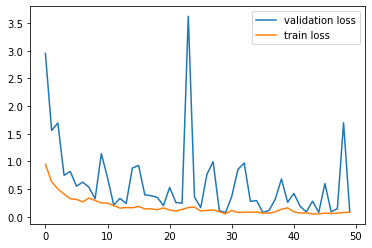

In [12]:
plt.plot(result.history['val_loss'], label='validation loss')
plt.plot(result.history['loss'], label='train loss')
plt.legend()
plt.show()

In [13]:
plt.plot(result.history['val_accuracy'], label='validation accuracy')
plt.plot(result.history['accuracy'], label='train accuracy')
plt.legend()
plt.show()

In [15]:
predict_and_save(model, test_path, class_names, "./team2.csv")